In [21]:
import torch
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from rendering import rendering
from model import Voxels
from tqdm import tqdm
from ml_helpers import training

In [22]:
from dataset import get_rays

# Camera/Dataset

In [34]:
batch_size = 1024
o, d, t = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                    torch.from_numpy(d).reshape(-1, 3),
                                     torch.from_numpy(t).reshape(-1, 3)), dim=1), batch_size=batch_size, shuffle=True)


test_o, test_d, test_t = get_rays('fox', mode='test')

In [35]:
test_o.shape

(10, 160000, 3)

In [36]:
# so we can say we have 10 test images and 400*400 images and 3 dimension

# Rendering

# Model

In [37]:
model = Voxels(scale=1.5)

In [38]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

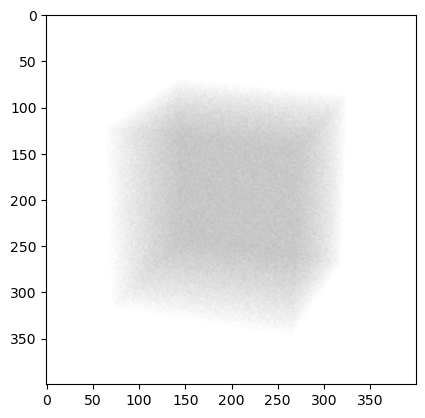

In [39]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

# Training

In [40]:
def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='cpu'):
        # scheduler is the learning rate scheduler or job scheduler
    
    training_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)
            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            
        scheduler.step()  # reduce the learning rate little by little over time
        
    #     torch.save(model.cpu(), 'model_nerf')
    #     model.to(device)
        
    # return training_loss

In [41]:
device = 'cpu'
nb_epochs = 15
lr = 1e-3
tn = 8
tf = 12
nb_bins = 100
gamma = 0.5

model = Voxels(scale=3, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma) # torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

100%|██████████| 14063/14063 [03:53<00:00, 60.26it/s]


In [42]:
training_loss

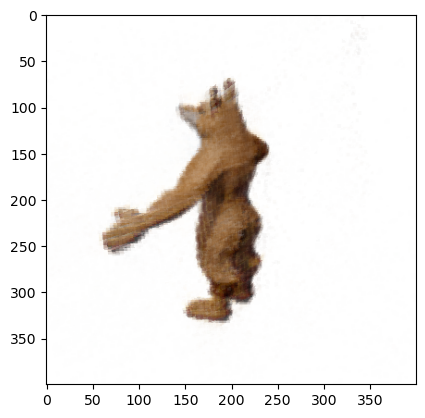

In [43]:
img = rendering(model, torch.from_numpy(o[0]), torch.from_numpy(d[0]).to(device), tn, tf, nb_bins=nb_bins, device=device)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
#here all the black values become white or equal 1 because we have normalized the values (in the rendering function) with white_bckgr=True and we have added 1 to it